# In this project, we will aim to forecast HDB prices. 
Firstly, we will clean the data, normalize it. 

Secondly, we will create visualizations in Python and Tableau to identify the factors affecting HDB Resale Prices.


Thirdly, we will deploy a time series forecasting model onto an app to allow for users to predict HDB prices, based on different features they would like their houses to have.

# Data  was retrieved from Data.gov.sg
We will now be reading in the data and merging the data sets accordingly.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime as dt

## 1. Data Cleaning and Pre-processing
Firstly, I will take a look at the data sets

In [6]:
hdb_1999_1999_prices = pd.read_csv("Data/resale-flat-prices-based-on-approval-date-1990-1999.csv")
hdb_2000_2012_prices = pd.read_csv("Data/resale-flat-prices-based-on-approval-date-2000-feb-2012.csv")
hdb_2012_2014_prices = pd.read_csv("Data/resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv")
hdb_2015_2016_prices = pd.read_csv("Data/resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv")
hdb_2017_2020_prices = pd.read_csv("Data/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv")

In [7]:
hdb_1999_1999_prices.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200


In [8]:
hdb_1999_1999_prices.columns.tolist()


['month',
 'town',
 'flat_type',
 'block',
 'street_name',
 'storey_range',
 'floor_area_sqm',
 'flat_model',
 'lease_commence_date',
 'resale_price']

In [9]:
hdb_2017_2020_prices.columns.tolist()

['month',
 'town',
 'flat_type',
 'block',
 'street_name',
 'storey_range',
 'floor_area_sqm',
 'flat_model',
 'lease_commence_date',
 'remaining_lease',
 'resale_price']

# Merging data frames
The columns are slight different for flat prices based on registration date and approval date files.

We will concat and stack the data frames row wise (axis = 0), by an inner join of common columns.

In [10]:
hdb_all = pd.concat([hdb_1999_1999_prices, hdb_2000_2012_prices,
          hdb_2012_2014_prices, hdb_2015_2016_prices, hdb_2017_2020_prices], 
          axis = 0,
          join = 'outer', 
          ignore_index=True,
          )

hdb_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826581 entries, 0 to 826580
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                826581 non-null  object 
 1   town                 826581 non-null  object 
 2   flat_type            826581 non-null  object 
 3   block                826581 non-null  object 
 4   street_name          826581 non-null  object 
 5   storey_range         826581 non-null  object 
 6   floor_area_sqm       826581 non-null  float64
 7   flat_model           826581 non-null  object 
 8   lease_commence_date  826581 non-null  int64  
 9   resale_price         826581 non-null  float64
 10  remaining_lease      117527 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 69.4+ MB


In [11]:
hdb_all.columns.tolist()

['month',
 'town',
 'flat_type',
 'block',
 'street_name',
 'storey_range',
 'floor_area_sqm',
 'flat_model',
 'lease_commence_date',
 'resale_price',
 'remaining_lease']

In [12]:
hdb_all['month'] = pd.to_datetime(hdb_all['month'])
hdb_all['lease_commence_date'] = pd.to_datetime(hdb_all['lease_commence_date'])

In [13]:
hdb_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826581 entries, 0 to 826580
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   month                826581 non-null  datetime64[ns]
 1   town                 826581 non-null  object        
 2   flat_type            826581 non-null  object        
 3   block                826581 non-null  object        
 4   street_name          826581 non-null  object        
 5   storey_range         826581 non-null  object        
 6   floor_area_sqm       826581 non-null  float64       
 7   flat_model           826581 non-null  object        
 8   lease_commence_date  826581 non-null  datetime64[ns]
 9   resale_price         826581 non-null  float64       
 10  remaining_lease      117527 non-null  object        
dtypes: datetime64[ns](2), float64(2), object(7)
memory usage: 69.4+ MB


In [14]:
# Let's loop through the data and see if there is anything missing
for col in hdb_all.columns:
    percent_missing = np.mean(hdb_all[col].isnull())
    print(f'{col} - {round(percent_missing*100)}%')

month - 0%
town - 0%
flat_type - 0%
block - 0%
street_name - 0%
storey_range - 0%
floor_area_sqm - 0%
flat_model - 0%
lease_commence_date - 0%
resale_price - 0%
remaining_lease - 86%


In [15]:
# Where are these nulls coming from?
# Not nulls months come from 2015 onwards
hdb_all[~hdb_all.remaining_lease.isnull()]['month'].dt.year.unique()

array([2015, 2016, 2017, 2018, 2019, 2020], dtype=int32)

The non-nulls come from 2015 onwards, in remaining_lease columns.

This means that before 2015 sales, remaining_lease data was not available.

I will clean this column and extract data first, to see if we can use it. 

Otherwise, I may perhaps drop this col, as there is too much missing data to be useful.

In [16]:
hdb_all[~hdb_all.remaining_lease.isnull()]['remaining_lease'].value_counts
# Let's clean the format into xx.xx years left for the lease

<bound method IndexOpsMixin.value_counts of 709054                    70
709055                    65
709056                    64
709057                    63
709058                    64
                 ...        
826576    66 years 03 months
826577    65 years 06 months
826578    66 years 04 months
826579    66 years 03 months
826580    66 years 09 months
Name: remaining_lease, Length: 117527, dtype: object>

In [17]:
hdb_all['remaining_lease'] = hdb_all['remaining_lease'].astype(str).str.lower().str.strip()

# Define function to clean
# \d : any digit from 0-9
# + one or more of the preceding item
def parse_remaining_lease_col_to_years(x):
    # case 1 : 70 
    if re.fullmatch(r'\d+', x):
        return float(x)
    # case 2 : 66 years 09 months
    #(?:...) : non capturing group
    # ? after non capturing group, makes the entire group optional
    # \s : white space
    # * : zero or more of previous item
    #\s* : skip any amount of white space
    #() : capturing group
    match = re.search(r'(?:(\d+)\s*years?)?\s*(?:(\d+)\s*months?)?', x)
    if match:
        years = int(match.group(1) or 0)
        months = int(match.group(2) or 0)
        total = years + months/12
        if total != 0 :
            return round(total,2)
        else :
            return np.nan
    # case 3 : nulls
    return np.nan

hdb_all['lease_years_left'] = hdb_all['remaining_lease'].apply(parse_remaining_lease_col_to_years)
hdb_all['lease_years_left'].loc[~hdb_all['lease_years_left'].isna()]

709054    70.00
709055    65.00
709056    64.00
709057    63.00
709058    64.00
          ...  
826576    66.25
826577    65.50
826578    66.33
826579    66.25
826580    66.75
Name: lease_years_left, Length: 117527, dtype: float64

In [18]:
hdb_all.drop('remaining_lease', axis = 1, inplace=True)
hdb_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826581 entries, 0 to 826580
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   month                826581 non-null  datetime64[ns]
 1   town                 826581 non-null  object        
 2   flat_type            826581 non-null  object        
 3   block                826581 non-null  object        
 4   street_name          826581 non-null  object        
 5   storey_range         826581 non-null  object        
 6   floor_area_sqm       826581 non-null  float64       
 7   flat_model           826581 non-null  object        
 8   lease_commence_date  826581 non-null  datetime64[ns]
 9   resale_price         826581 non-null  float64       
 10  lease_years_left     117527 non-null  float64       
dtypes: datetime64[ns](2), float64(3), object(6)
memory usage: 69.4+ MB


In [19]:
hdb_all["flat_type"].value_counts()

flat_type
4 ROOM              309314
3 ROOM              272580
5 ROOM              170408
EXECUTIVE            62641
2 ROOM                9863
1 ROOM                1273
MULTI GENERATION       279
MULTI-GENERATION       223
Name: count, dtype: int64

In [20]:
# Ensure all are in lower case, no white spaces
hdb_all['flat_type'] = hdb_all['flat_type'].str.strip().str.lower()

# There are duplicates : multi generation and multi-generation
hdb_all['flat_type'] = hdb_all['flat_type'].str.replace('multi-generation', 'multi generation')

hdb_all.flat_type.value_counts()

flat_type
4 room              309314
3 room              272580
5 room              170408
executive            62641
2 room                9863
1 room                1273
multi generation       502
Name: count, dtype: int64

In [21]:
hdb_all['flat_model'].value_counts()

flat_model
Model A                   158008
Improved                  143763
New Generation             98672
NEW GENERATION             78898
IMPROVED                   73593
MODEL A                    70381
Premium Apartment          35029
Simplified                 30702
SIMPLIFIED                 23258
Standard                   22479
Apartment                  22103
STANDARD                   17375
Maisonette                 14694
MAISONETTE                 12215
APARTMENT                   9901
Model A2                    9109
DBSS                        1609
Adjoined flat               1085
MODEL A-MAISONETTE           982
Model A-Maisonette           907
Terrace                      395
MULTI GENERATION             279
Type S1                      272
TERRACE                      247
Multi Generation             223
Type S2                      129
Premium Maisonette            82
Improved-Maisonette           70
IMPROVED-MAISONETTE           44
Premium Apartment Loft        31

<Axes: ylabel='flat_model'>

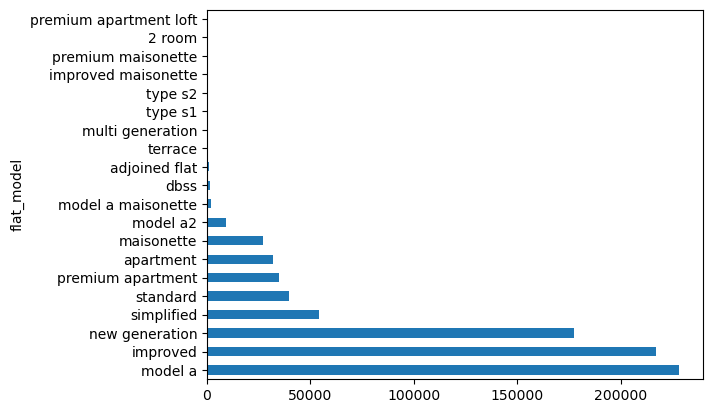

In [22]:
# There are once again, duplicate values. We will replace them.
# FIrstly, let's convert all to lower. Then replace all '-' with ' ', using regex.

hdb_all['flat_model'] = (
    hdb_all['flat_model']
    .str.lower()
    .str.replace('-',' ', regex = True) 
    .str.strip()) # removes trailing spaces at end/start

hdb_all['flat_model'].replace({'premium apartment loft':'premium apartment'})
hdb_all['flat_model'].value_counts().plot(kind='barh')

# simple bar chart showing distributions, across flat models

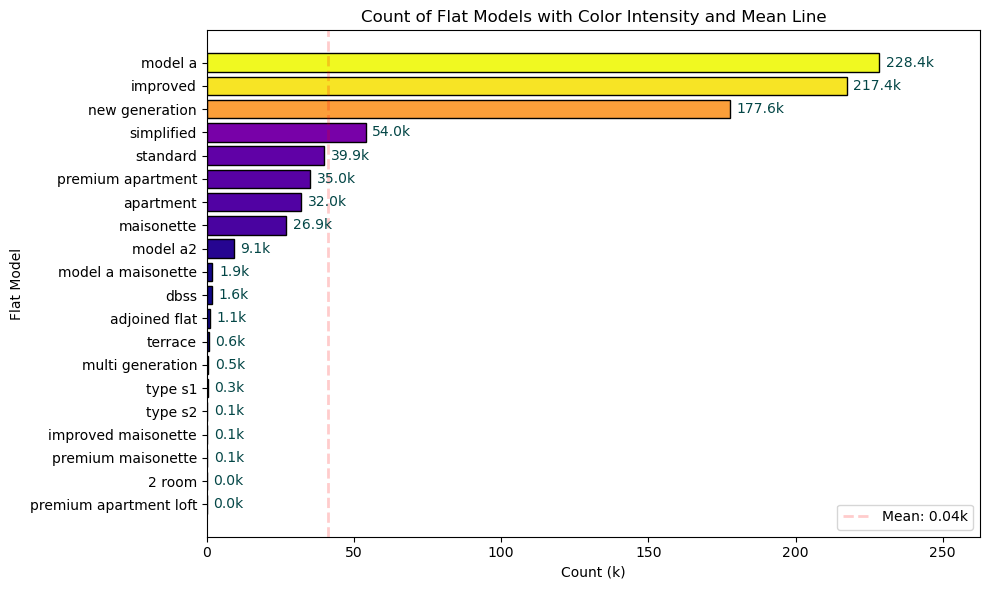

In [23]:
# Modern bar chart with more numerical information of distributions, across flat models
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Get sorted value counts
counts = (hdb_all['flat_model'].value_counts()/1000).sort_values()
norm = mcolors.Normalize(vmin=counts.min(), vmax=counts.max())
colors = cm.plasma(norm(counts.values))

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
bars = ax.barh(y=counts.index, width=counts.values, color=colors, edgecolor='black')

# Labels
ax.set_xlabel('Count (k)')
ax.set_ylabel('Flat Model')
ax.set_title('Count of Flat Models with Color Intensity and Mean Line')

# Looping through each bar in the chart :
for bar in bars:
    width = bar.get_width() # returns length of bar (value represented by the bar)
    ax.text(                # creates text label next to each bar
        x = width + max(counts) * 0.01,           # x coordinate where text is displayed
        y = bar.get_y() + bar.get_height() / 2,   # y coordinate where text is displayed
        s = f'{width :.1f}k',                     # format in thousands # s : string to display
        va='center', ha='left', color = "#034646", # vertical alighnment, horizontal alignment relative to (x,y)
        fontweight ='light')

# Calculate mean
mean_count = counts.mean()

# Add vertical mean line
ax.axvline(
    mean_count,
    color='red',
    linestyle='--',
    linewidth=2,
    alpha=0.2,
    label=f'Mean: {mean_count / 1000:.2f}k'
)

# Show legend
ax.legend()
ax.set_xlim(right=max(counts)*1.15)

plt.tight_layout()
plt.show()


In [24]:
hdb_all['storey_range'].value_counts().sort_index(ascending=True)

# 01 to 03 is duplicated with 01 to 05. We will replace all to 01 to 05.
# inconsistent floor level ranges

storey_range
01 TO 03    168985
01 TO 05      2700
04 TO 06    209705
06 TO 10      2474
07 TO 09    189109
10 TO 12    160250
11 TO 15      1259
13 TO 15     52212
16 TO 18     19449
16 TO 20       265
19 TO 21      9422
21 TO 25        92
22 TO 24      6053
25 TO 27      2544
26 TO 30        39
28 TO 30      1049
31 TO 33       265
31 TO 35         2
34 TO 36       267
36 TO 40         7
37 TO 39       255
40 TO 42       132
43 TO 45        16
46 TO 48        21
49 TO 51         9
Name: count, dtype: int64

## Floor range is probably a factor that also affects housing prices.

We cannot leave the information inconsistent like this as it will affect our regression later.

I will be cleaning this data and using the average values of each range instead.



In [25]:
hdb_all['storey_range'].value_counts().sort_index(ascending=True).index.tolist()

['01 TO 03',
 '01 TO 05',
 '04 TO 06',
 '06 TO 10',
 '07 TO 09',
 '10 TO 12',
 '11 TO 15',
 '13 TO 15',
 '16 TO 18',
 '16 TO 20',
 '19 TO 21',
 '21 TO 25',
 '22 TO 24',
 '25 TO 27',
 '26 TO 30',
 '28 TO 30',
 '31 TO 33',
 '31 TO 35',
 '34 TO 36',
 '36 TO 40',
 '37 TO 39',
 '40 TO 42',
 '43 TO 45',
 '46 TO 48',
 '49 TO 51']

In [26]:
hdb_all['town']=hdb_all['town'].str.lower()

In [27]:
hdb_all

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,lease_years_left
0,1990-01-01,ang mo kio,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,improved,1970-01-01 00:00:00.000001977,9000.0,NaN
1,1990-01-01,ang mo kio,1 room,309,ANG MO KIO AVE 1,04 TO 06,31.0,improved,1970-01-01 00:00:00.000001977,6000.0,NaN
2,1990-01-01,ang mo kio,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,improved,1970-01-01 00:00:00.000001977,8000.0,NaN
3,1990-01-01,ang mo kio,1 room,309,ANG MO KIO AVE 1,07 TO 09,31.0,improved,1970-01-01 00:00:00.000001977,6000.0,NaN
4,1990-01-01,ang mo kio,3 room,216,ANG MO KIO AVE 1,04 TO 06,73.0,new generation,1970-01-01 00:00:00.000001976,47200.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
826576,2020-09-01,yishun,5 room,716,YISHUN ST 71,07 TO 09,131.0,improved,1970-01-01 00:00:00.000001987,440000.0,66.25
826577,2020-09-01,yishun,5 room,760,YISHUN ST 72,07 TO 09,122.0,improved,1970-01-01 00:00:00.000001987,458000.0,65.50
826578,2020-09-01,yishun,5 room,835,YISHUN ST 81,04 TO 06,122.0,improved,1970-01-01 00:00:00.000001987,490000.0,66.33
826579,2020-09-01,yishun,executive,791,YISHUN AVE 2,04 TO 06,146.0,maisonette,1970-01-01 00:00:00.000001987,558000.0,66.25


# 2. Data visualizations and EDA
- Python
- Tableau (Separately)

### Average resale price by year
### Average resale price by flat type
### Average resale price by town
### Average resale price by flat model
### Average resale price by storey range


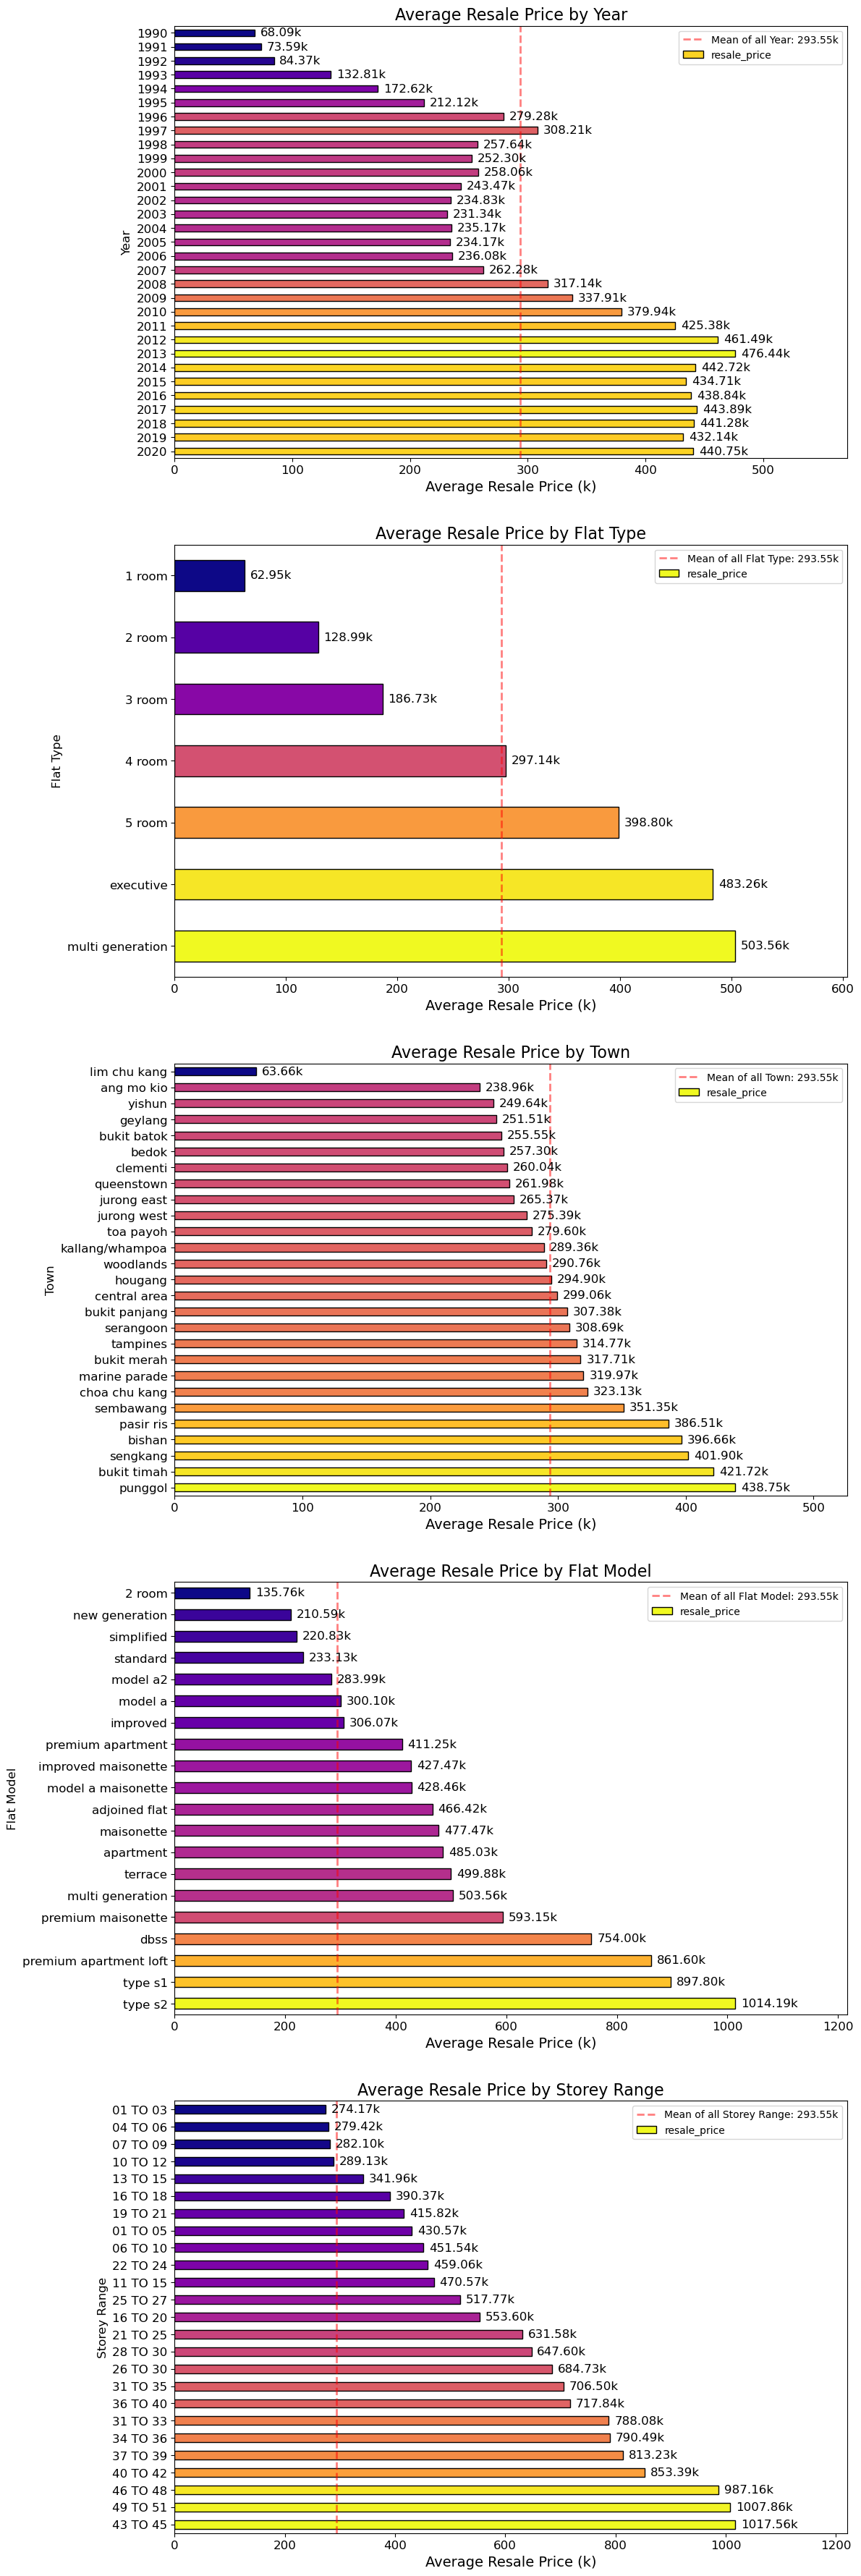

In [28]:
hdb_all['year'] = hdb_all['month'].dt.year
grouped_cols = ['year','flat_type', 'town', 'flat_model', 'storey_range', 'floor_']
titles = ['Year','Flat Type', 'Town', 'Flat Model', 'Storey Range']
fig, axes = plt.subplots(nrows=5, ncols = 1, figsize=(12,45))

for ax, i, title in zip(axes,grouped_cols,titles):
    group = (hdb_all.groupby(i)['resale_price'].mean().round(2)/1000)

    if i == 'year':
        group = group.sort_index(ascending=False) # sort by Year index
    else:
        group = group.sort_values(ascending=False) # sort low to high

    # Normalize values to map to colormap, higher price = more intense color
    norm = mcolors.Normalize(vmin=group.min(), vmax=group.max())
    colors = cm.plasma(norm(group.values))

    group.plot(kind='barh', ax=ax, color=colors, edgecolor='black')

    # Add value labels at the end of each bar
    for idx, val in enumerate(group):
        ax.text(val+group.max()*0.01, idx, f'{val:.2f}k', va='center', ha='left', fontsize=12, color='black')
    mean_val = (hdb_all['resale_price'].mean() / 1000)
    ax.axvline(mean_val, alpha=0.5, color='red', linestyle='--', linewidth=2, label=f'Mean of all {title}: {mean_val:.2f}k')

    ax.set_title(f"Average Resale Price by {title}",fontsize=16)
    ax.set_xlabel('Average Resale Price (k)', fontsize=14)
    ax.tick_params(labelsize=12)
    ax.set_ylabel(title, fontsize=12)
    ax.legend()
    ax.set_xlim(0, group.max()*1.2) # extends x axis so labels dont get cut off

plt.tight_layout
plt.show()



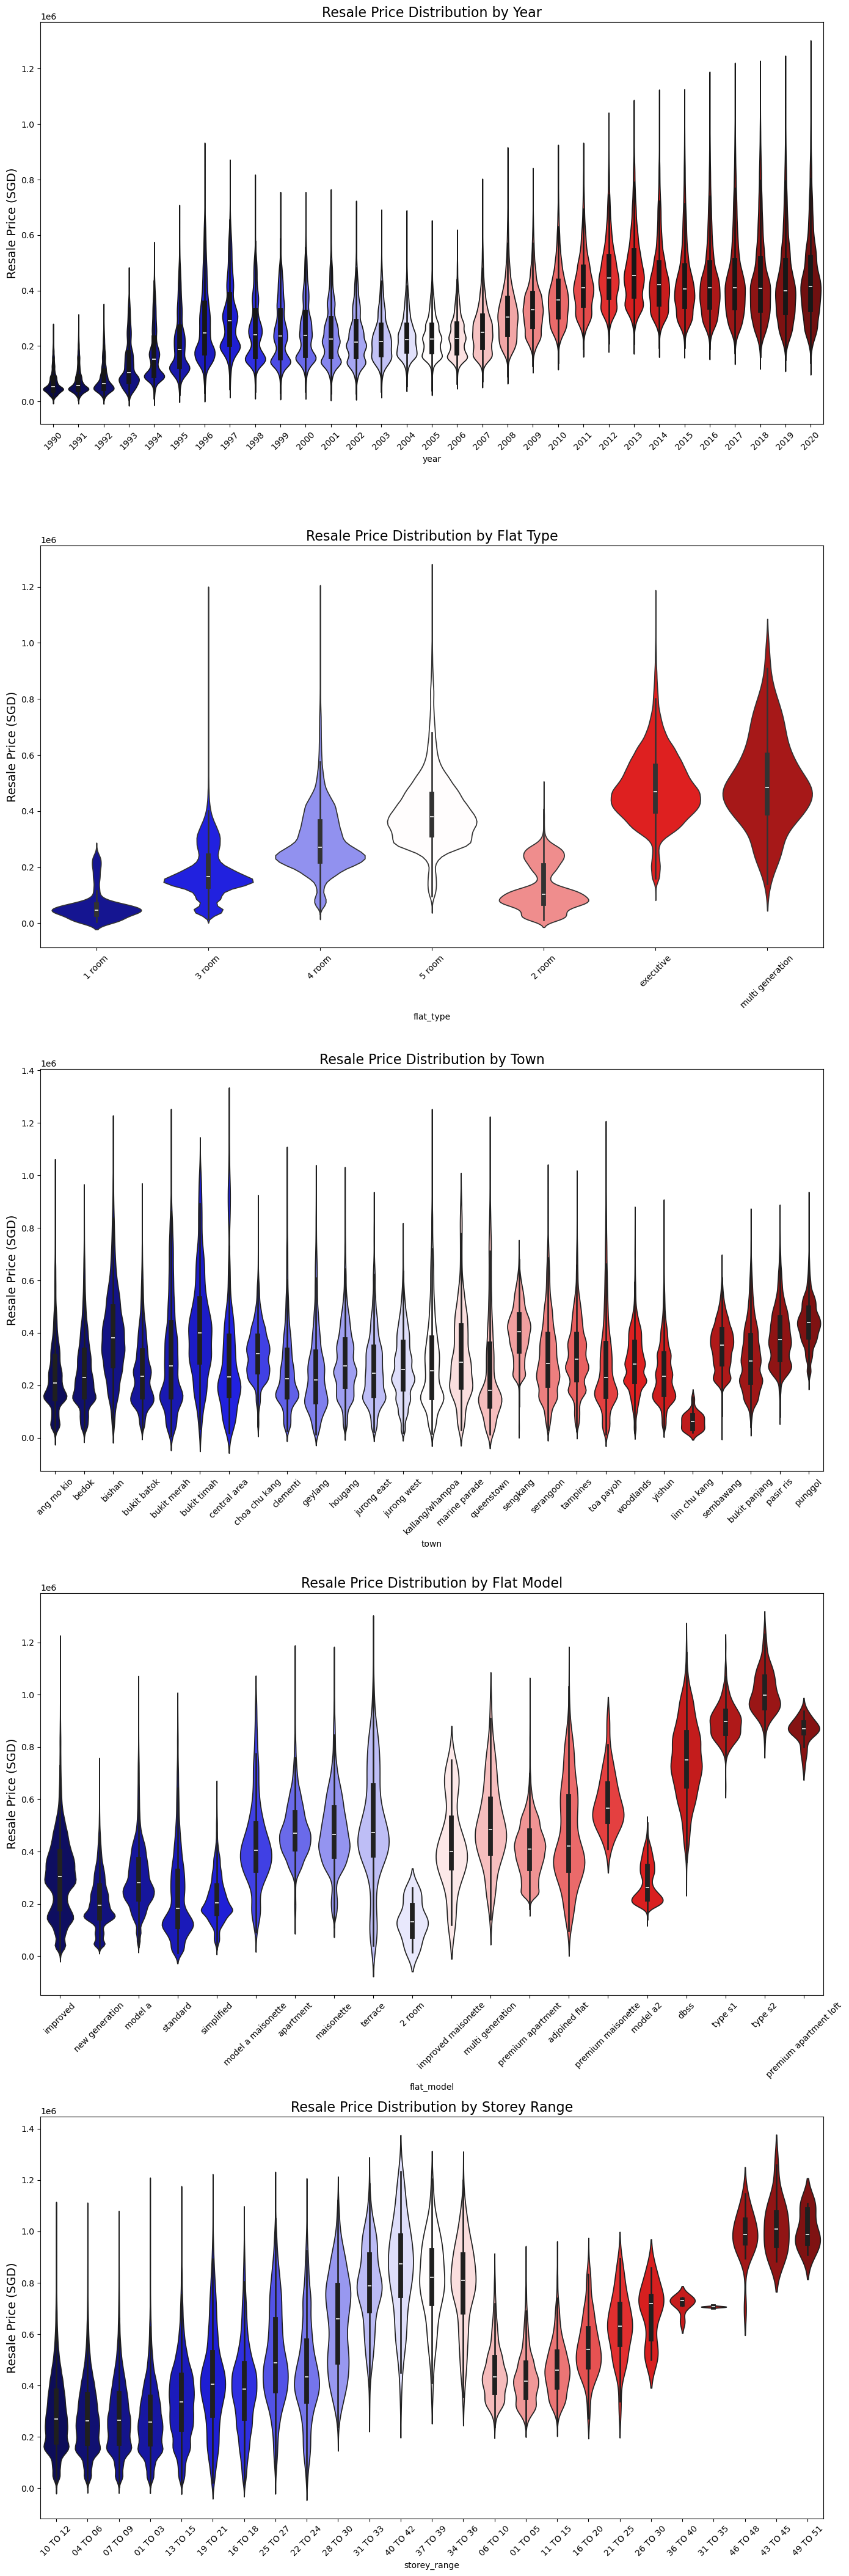

In [29]:
# violin plots

plt.figure(figsize=(14, 50))  # Large height for 5 plots stacked vertically

for idx, (col, title) in enumerate(zip(grouped_cols, titles), 1):
    plt.subplot(len(grouped_cols), 1, idx)
    sns.violinplot(
        data=hdb_all,
        x=col, hue = col,
        y='resale_price', palette='seismic',
        inner='box', legend = False
    )
    plt.title(f'Resale Price Distribution by {title}', fontsize=16)
    plt.ylabel('Resale Price (SGD)', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()


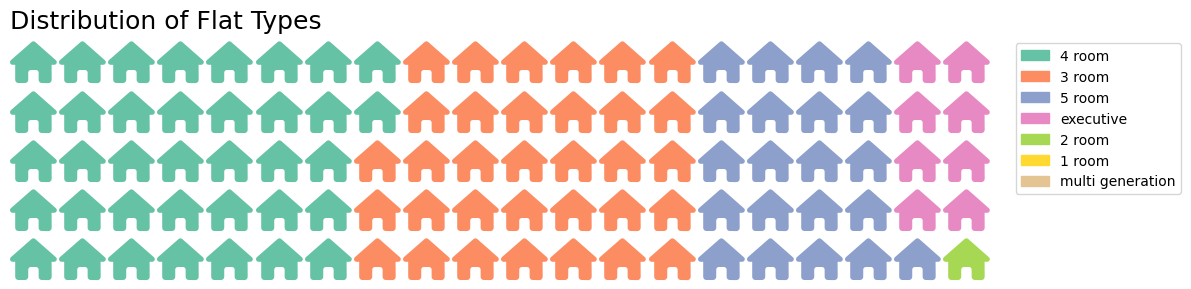

In [30]:
from pywaffle import Waffle

# Step 1: Group and count flat types
flat_type_counts = hdb_all['flat_type'].value_counts(normalize=True) * 100
flat_type_percents = flat_type_counts.round().astype(int).to_dict()

# Step 2: Create waffle chart
fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    values=flat_type_percents,
    icons='home',
    icon_size=30,
    title={'label': 'Distribution of Flat Types', 'loc': 'left', 'fontsize':18},
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.025, 1)},
    figsize=(12, 6),
    block_arranging_style='snake',  # Optional, snake-like pattern
)

plt.show()



In [31]:
hdb_all

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,lease_years_left,year
0,1990-01-01,ang mo kio,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,improved,1970-01-01 00:00:00.000001977,9000.0,NaN,1990
1,1990-01-01,ang mo kio,1 room,309,ANG MO KIO AVE 1,04 TO 06,31.0,improved,1970-01-01 00:00:00.000001977,6000.0,NaN,1990
2,1990-01-01,ang mo kio,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,improved,1970-01-01 00:00:00.000001977,8000.0,NaN,1990
3,1990-01-01,ang mo kio,1 room,309,ANG MO KIO AVE 1,07 TO 09,31.0,improved,1970-01-01 00:00:00.000001977,6000.0,NaN,1990
4,1990-01-01,ang mo kio,3 room,216,ANG MO KIO AVE 1,04 TO 06,73.0,new generation,1970-01-01 00:00:00.000001976,47200.0,NaN,1990
...,...,...,...,...,...,...,...,...,...,...,...,...
826576,2020-09-01,yishun,5 room,716,YISHUN ST 71,07 TO 09,131.0,improved,1970-01-01 00:00:00.000001987,440000.0,66.25,2020
826577,2020-09-01,yishun,5 room,760,YISHUN ST 72,07 TO 09,122.0,improved,1970-01-01 00:00:00.000001987,458000.0,65.50,2020
826578,2020-09-01,yishun,5 room,835,YISHUN ST 81,04 TO 06,122.0,improved,1970-01-01 00:00:00.000001987,490000.0,66.33,2020
826579,2020-09-01,yishun,executive,791,YISHUN AVE 2,04 TO 06,146.0,maisonette,1970-01-01 00:00:00.000001987,558000.0,66.25,2020


In [32]:
hdb_all

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,lease_years_left,year
0,1990-01-01,ang mo kio,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,improved,1970-01-01 00:00:00.000001977,9000.0,NaN,1990
1,1990-01-01,ang mo kio,1 room,309,ANG MO KIO AVE 1,04 TO 06,31.0,improved,1970-01-01 00:00:00.000001977,6000.0,NaN,1990
2,1990-01-01,ang mo kio,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,improved,1970-01-01 00:00:00.000001977,8000.0,NaN,1990
3,1990-01-01,ang mo kio,1 room,309,ANG MO KIO AVE 1,07 TO 09,31.0,improved,1970-01-01 00:00:00.000001977,6000.0,NaN,1990
4,1990-01-01,ang mo kio,3 room,216,ANG MO KIO AVE 1,04 TO 06,73.0,new generation,1970-01-01 00:00:00.000001976,47200.0,NaN,1990
...,...,...,...,...,...,...,...,...,...,...,...,...
826576,2020-09-01,yishun,5 room,716,YISHUN ST 71,07 TO 09,131.0,improved,1970-01-01 00:00:00.000001987,440000.0,66.25,2020
826577,2020-09-01,yishun,5 room,760,YISHUN ST 72,07 TO 09,122.0,improved,1970-01-01 00:00:00.000001987,458000.0,65.50,2020
826578,2020-09-01,yishun,5 room,835,YISHUN ST 81,04 TO 06,122.0,improved,1970-01-01 00:00:00.000001987,490000.0,66.33,2020
826579,2020-09-01,yishun,executive,791,YISHUN AVE 2,04 TO 06,146.0,maisonette,1970-01-01 00:00:00.000001987,558000.0,66.25,2020


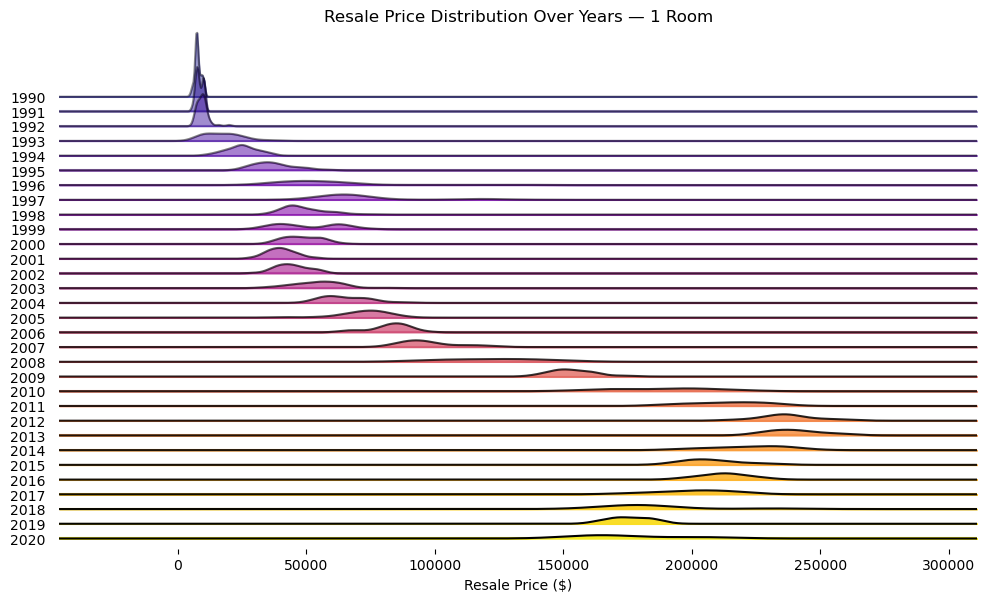

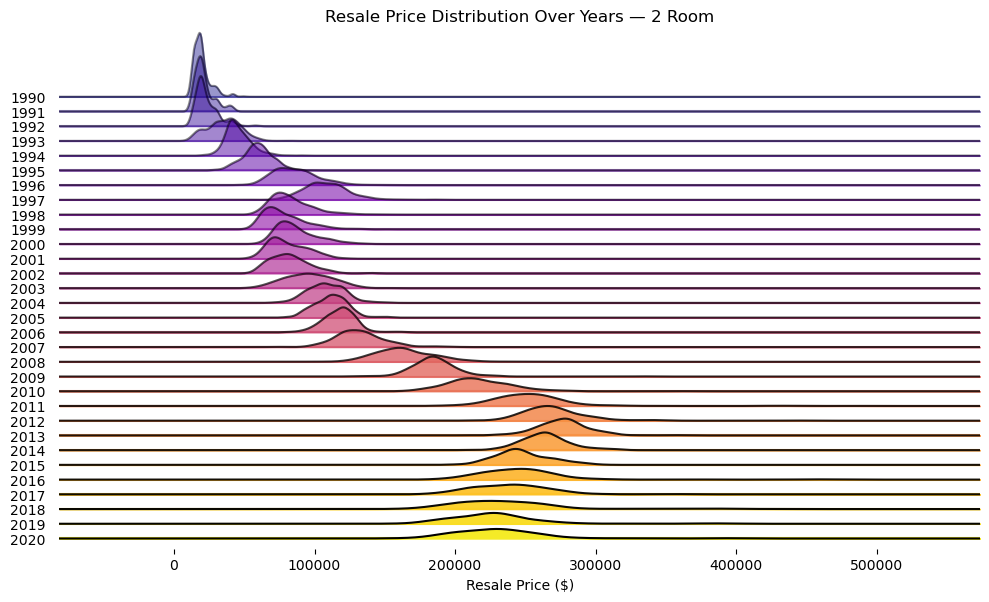

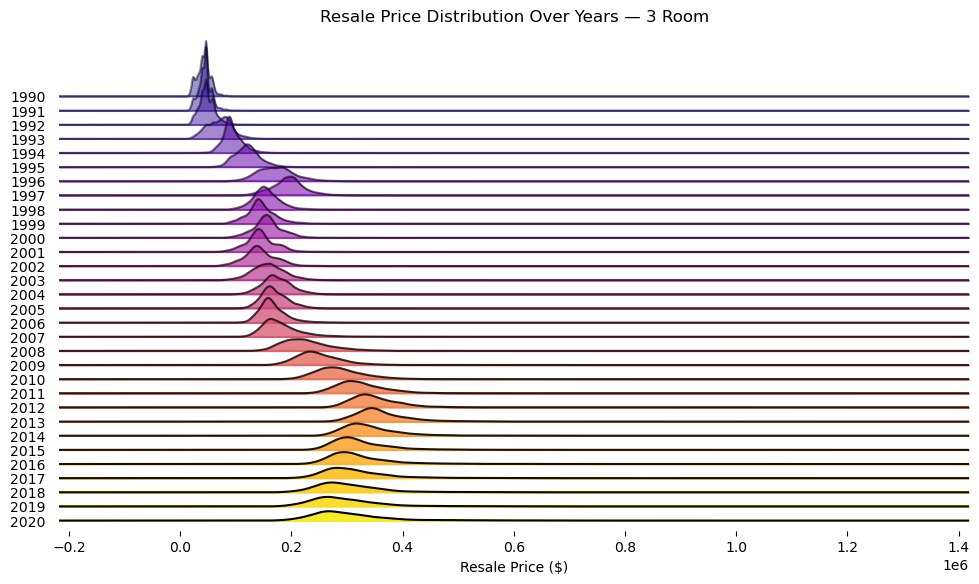

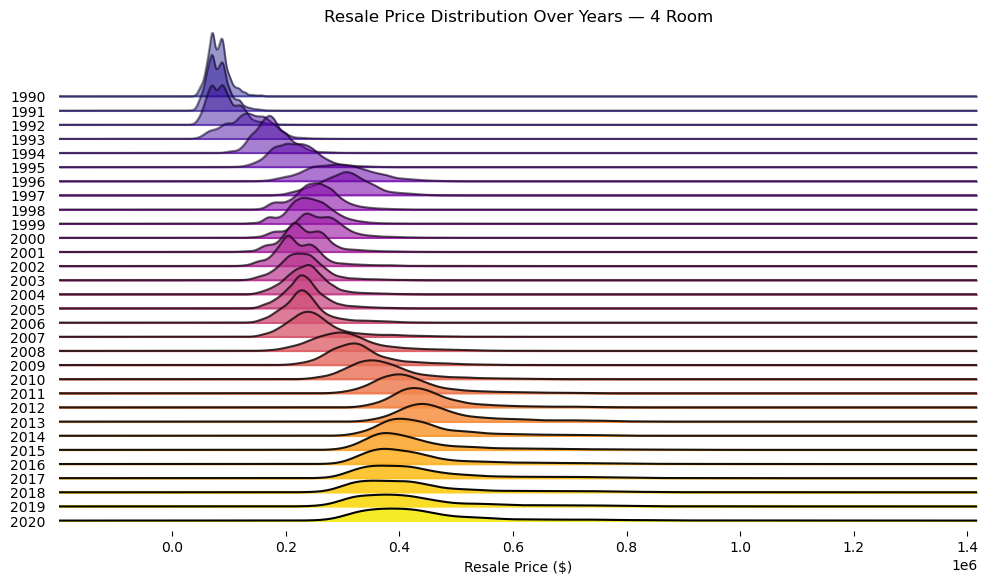

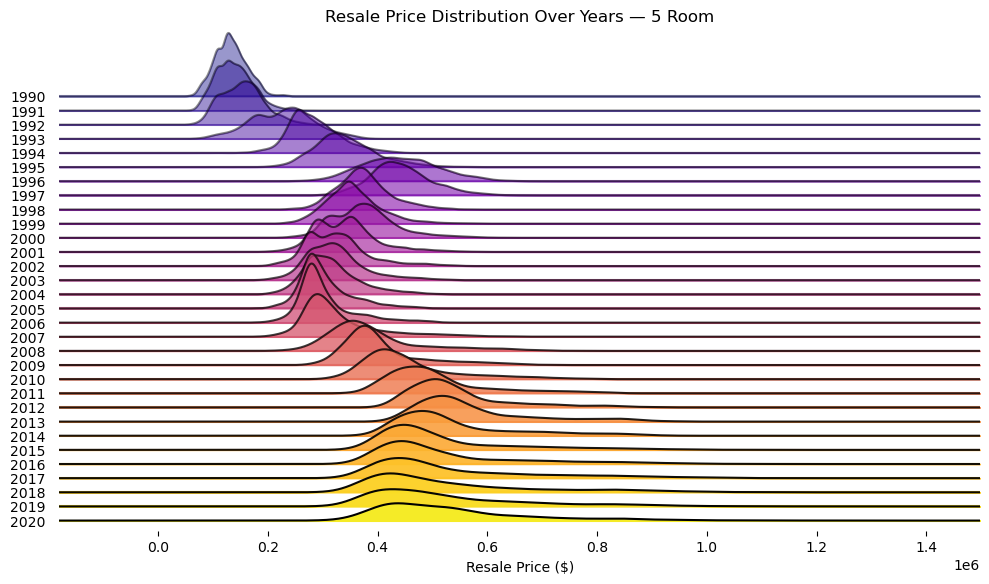

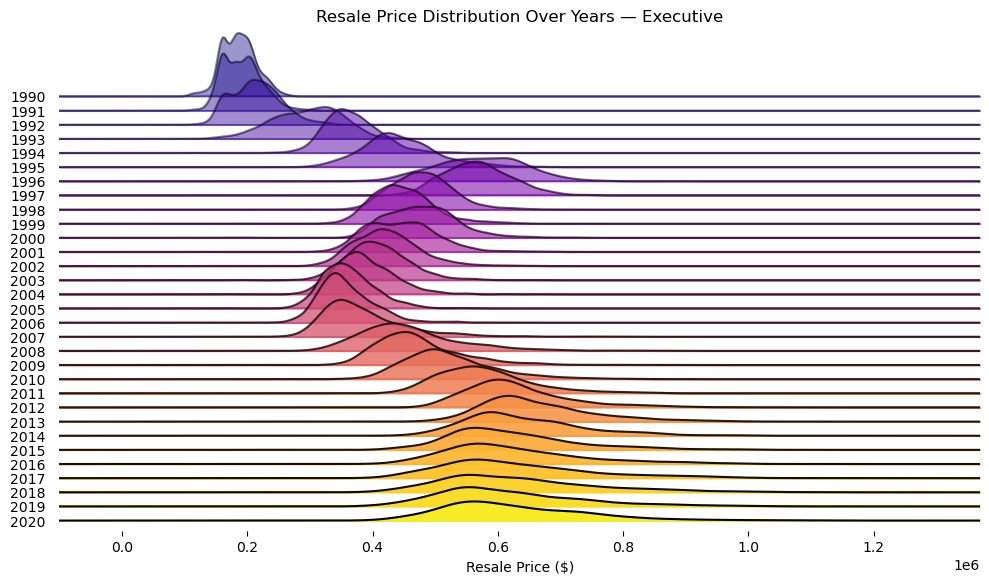

In [33]:
# Ridgeline plot : flat prices across the year, for each flat type
# Ridge plot to visalize distribution of variable across the groups of flats
# See the shape of dist, comparison betw groups and trends over time
from joypy import joyplot

flat_types = ['1 room', '2 room', '3 room', '4 room', '5 room', 'executive']

for flat in flat_types:
    data = hdb_all[hdb_all['flat_type'].str.lower() == flat]

    # Skip if no data
    if data.empty:
        continue

    fig, ax = joyplot(
        data,
        by='year',
        column='resale_price',
        figsize=(10, 6),
        title=f'Resale Price Distribution Over Years — {flat.title()}',
        colormap=plt.cm.plasma,
        kind='kde',
        fade=True,
        alpha=0.8,
        overlap=1
    )
    plt.xlabel('Resale Price ($)')
    plt.show()



# Adjust prices to inflation, using Consumer Price Index (CPI)

In [34]:
cpi_1961_2020 = pd.read_csv("Data/CPI.csv")
cpi_1961_2020['month'] = pd.to_datetime(cpi_1961_2020['month'], format = '%Y %b' )

In [35]:
hdb_all = hdb_all.merge(cpi_1961_2020, on='month', how = 'left')
# Real price = (normal price / cpi at that time) x 100 (base cpi)

hdb_all['resale_price_adjusted'] = hdb_all['resale_price'] / hdb_all['cpi'] * 100

# How has prices changed over time, with inflation? 
Adjusted for inflation and unadjusted.

In [36]:
hdb_all.groupby('month')[['resale_price', 'resale_price_adjusted']].mean().reset_index()

,month,resale_price,resale_price_adjusted
0,1990-01-01,65214.120770,107094.493332
1,1990-02-01,67871.052632,110766.479472
2,1990-03-01,66603.433913,108701.256550
3,1990-04-01,65930.152818,107516.434529
4,1990-05-01,67837.128535,111030.031318
...,...,...,...
364,2020-05-01,445865.509642,443656.102253
365,2020-06-01,432059.865879,429965.931792
366,2020-07-01,436437.791330,444139.164441
367,2020-08-01,447903.669219,448581.026570


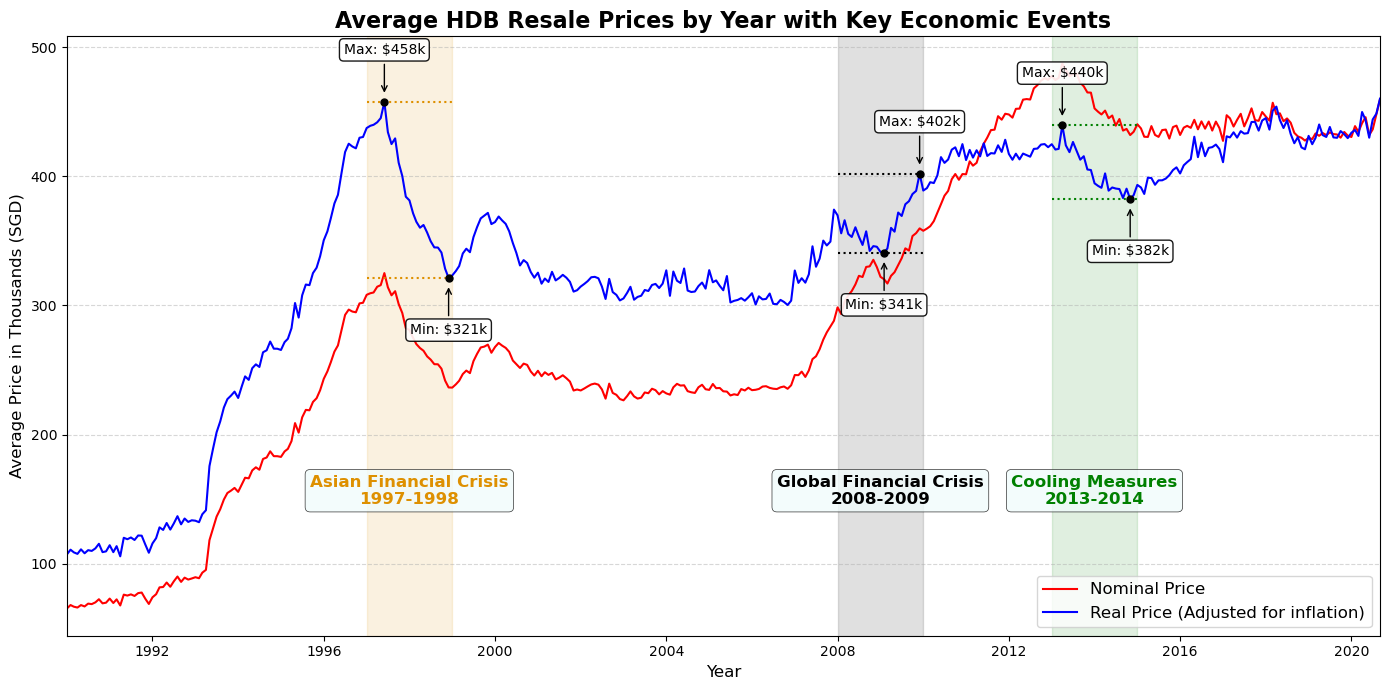

In [37]:
# Compute average prices per month in each year
yearly_avg = hdb_all.groupby('month')[['resale_price', 'resale_price_adjusted']].mean().reset_index()

# Plot yearly average
plt.figure(figsize=(14, 7))
plt.plot(yearly_avg['month'], yearly_avg['resale_price'] / 1000, label='Nominal Price', color='red')
plt.plot(yearly_avg['month'], yearly_avg['resale_price_adjusted'] / 1000, label='Real Price (Adjusted for inflation)', color='blue')
plt.title('Average HDB Resale Prices by Year with Key Economic Events', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.xlim(yearly_avg['month'].min(), yearly_avg['month'].max())
plt.ylabel('Average Price in Thousands (SGD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

ax = plt.gca()

# Highlight periods and annotate
highlights = [
    {'start': pd.Timestamp('1997-01-01'), 'end': pd.Timestamp('1998-12-31'), 'color': "#DE9000", 'label': 'Asian Financial Crisis\n1997-1998'},
    {'start': pd.Timestamp('2008-01-01'), 'end': pd.Timestamp('2009-12-31'), 'color': 'black', 'label': 'Global Financial Crisis\n2008-2009'},
    {'start': pd.Timestamp('2013-01-01'), 'end': pd.Timestamp('2014-12-31'), 'color': 'green', 'label': 'Cooling Measures\n2013-2014'}
]

max_price = max(yearly_avg['resale_price'].max() / 1000, yearly_avg['resale_price_adjusted'].max() / 1000)

for h in highlights:
    # Shade the area with lighter alpha
    ax.axvspan(h['start'], h['end'], color=h['color'], alpha=0.12)

    # Filter data for that time range
    mask = (yearly_avg['month'] >= h['start']) & (yearly_avg['month'] <= h['end'])
    data_in_range = yearly_avg.loc[mask]
    # Get min and max prices (in thousands)
    min_price_k = data_in_range['resale_price_adjusted'].min() / 1000
    max_price_k = data_in_range['resale_price_adjusted'].max() / 1000

    # Horizontal lines for min and max prices
    ax.hlines(y=min_price_k, xmin=h['start'], xmax=h['end'], color=h['color'], linestyle=':', linewidth=1.5)
    ax.hlines(y=max_price_k, xmin=h['start'], xmax=h['end'], color=h['color'], linestyle=':', linewidth=1.5)

    # Highlight min and max points on the line with markers
    min_idx = data_in_range['resale_price_adjusted'].idxmin()
    max_idx = data_in_range['resale_price_adjusted'].idxmax()
    ax.plot(yearly_avg.loc[min_idx, 'month'], min_price_k, 'o', color='black', markersize=5, markeredgecolor='black')
    ax.plot(yearly_avg.loc[max_idx, 'month'], max_price_k, 'o', color='black', markersize=5, markeredgecolor='black')

    # Annotate min price with offset + arrow
    ax.annotate(
        f'Min: ${min_price_k:,.0f}k',
        xy=(yearly_avg.loc[min_idx, 'month'], min_price_k-5),
        xytext=(yearly_avg.loc[min_idx, 'month'], min_price_k - 35),
        textcoords='data',
        ha='center', va='top',
        fontsize=10,
        fontweight='light',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9),
        arrowprops=dict(arrowstyle='->', color="#000000", lw=1)
    )

    # Annotate max price with offset + arrow
    ax.annotate(
        f'Max: ${max_price_k:,.0f}k',
        xy=(yearly_avg.loc[max_idx, 'month'], max_price_k+5),
        xytext=(yearly_avg.loc[max_idx, 'month'], max_price_k + 35),
        textcoords='data',
        ha='center', va='bottom',
        fontsize=10,
        fontweight='light',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9),
        arrowprops=dict(arrowstyle='->', color="#000000", lw=1)
    )

    # Annotate event title
    mid = h['start'] + (h['end'] - h['start']) / 2
    y_pos = max_price * 0.3

    ax.text(mid, y_pos, h['label'], color=h['color'], 
            fontsize=12, fontweight='bold', ha='center', 
            bbox=dict(boxstyle='round,pad=0.3', facecolor="#F1FCFC", alpha=0.8, 
                      edgecolor='#010101', linewidth=0.5))

plt.tight_layout()
plt.show()


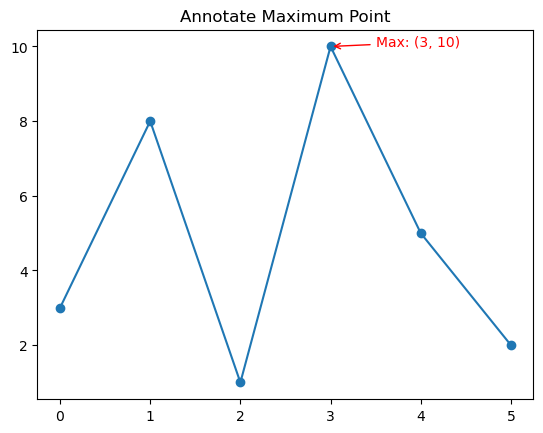

In [38]:
import matplotlib.pyplot as plt

x = [0, 1, 2, 3, 4, 5]
y = [3, 8, 1, 10, 5, 2]

# Find max y and corresponding x
max_y = max(y)
max_index = y.index(max_y)
max_x = x[max_index]

plt.plot(x, y, marker='o')
plt.annotate(f'Max: ({max_x}, {max_y})',
             xy=(max_x, max_y),             # point to annotate
             xytext=(max_x + 0.5, max_y),   # position of text
             arrowprops=dict(arrowstyle='->', color='red'),
             color='red')

plt.title("Annotate Maximum Point")
plt.show()


In [39]:
hdb_all

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,lease_years_left,year,cpi,resale_price_adjusted
0,1990-01-01,ang mo kio,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,improved,1970-01-01 00:00:00.000001977,9000.0,NaN,1990,60.894,14779.781259
1,1990-01-01,ang mo kio,1 room,309,ANG MO KIO AVE 1,04 TO 06,31.0,improved,1970-01-01 00:00:00.000001977,6000.0,NaN,1990,60.894,9853.187506
2,1990-01-01,ang mo kio,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,improved,1970-01-01 00:00:00.000001977,8000.0,NaN,1990,60.894,13137.583342
3,1990-01-01,ang mo kio,1 room,309,ANG MO KIO AVE 1,07 TO 09,31.0,improved,1970-01-01 00:00:00.000001977,6000.0,NaN,1990,60.894,9853.187506
4,1990-01-01,ang mo kio,3 room,216,ANG MO KIO AVE 1,04 TO 06,73.0,new generation,1970-01-01 00:00:00.000001976,47200.0,NaN,1990,60.894,77511.741715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826576,2020-09-01,yishun,5 room,716,YISHUN ST 71,07 TO 09,131.0,improved,1970-01-01 00:00:00.000001987,440000.0,66.25,2020,99.869,440577.156074
826577,2020-09-01,yishun,5 room,760,YISHUN ST 72,07 TO 09,122.0,improved,1970-01-01 00:00:00.000001987,458000.0,65.50,2020,99.869,458600.767005
826578,2020-09-01,yishun,5 room,835,YISHUN ST 81,04 TO 06,122.0,improved,1970-01-01 00:00:00.000001987,490000.0,66.33,2020,99.869,490642.741992
826579,2020-09-01,yishun,executive,791,YISHUN AVE 2,04 TO 06,146.0,maisonette,1970-01-01 00:00:00.000001987,558000.0,66.25,2020,99.869,558731.938840


# Time series forecasting model to predict HDB prices
Deployed on a webapp with Streamlit

# Forecasting CPI with simple linear regression
We will be using SARIMA to forecast CPI, as CPI is a time series data with season


In [40]:
from sklearn.linear_model import LinearRegression
import numpy as np

import matplotlib.pyplot as plt

# Prepare data for linear regression: use month as ordinal (integer)
cpi_ts = hdb_all.drop_duplicates('month').set_index('month').sort_index()['cpi']
X = np.arange(len(cpi_ts)).reshape(-1, 1)
y = cpi_ts.values

# Fit linear regression
lr = LinearRegression()
lr.fit(X, y)

# Predict for existing and future months
future_steps = 240
X_future = np.arange(len(cpi_ts) + future_steps).reshape(-1, 1)
cpi_pred = lr.predict(X_future)

# Build DataFrame for forecasted CPI
future_months = pd.date_range(start=cpi_ts.index.min(), periods=len(X_future), freq='MS')
cpi_lr_forecast_df = pd.DataFrame({'month': future_months, 'cpi': cpi_pred})
cpi_lr_forecast_df['year'] = cpi_lr_forecast_df['month'].dt.year

In [41]:
# Show forecasted CPI for next 10 years
cpi_lr_forecast_df.tail(12)

,month,cpi,year
597,2039-10-01,142.229472,2039
598,2039-11-01,142.369569,2039
599,2039-12-01,142.509666,2039
600,2040-01-01,142.649762,2040
601,2040-02-01,142.789859,2040
602,2040-03-01,142.929956,2040
603,2040-04-01,143.070053,2040
604,2040-05-01,143.210150,2040
605,2040-06-01,143.350246,2040
606,2040-07-01,143.490343,2040


In [42]:
cpi_forecast_2020_2040=cpi_lr_forecast_df.groupby('year')['cpi'].median().loc[2025:2040]
cpi_forecast_2020_2040
# to csv:
# Save the CPI forecast (future_forecast) as CSV
cpi_forecast_2020_2040.to_csv('for_model_future_cpi_forecast.csv', header=True)

# Inputting forecasted CPI into Random Forest Model that will predict future DB prices based on selected features. 

### Machine Learning Model for Forecasting Future HDB Prices (Random Forest Regressor)




In [ ]:
hdb_all


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,lease_years_left,year,cpi,resale_price_adjusted
0,1990-01-01,ang mo kio,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,improved,1970-01-01 00:00:00.000001977,9000.0,NaN,1990,60.894,14779.781259
1,1990-01-01,ang mo kio,1 room,309,ANG MO KIO AVE 1,04 TO 06,31.0,improved,1970-01-01 00:00:00.000001977,6000.0,NaN,1990,60.894,9853.187506
2,1990-01-01,ang mo kio,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,improved,1970-01-01 00:00:00.000001977,8000.0,NaN,1990,60.894,13137.583342
3,1990-01-01,ang mo kio,1 room,309,ANG MO KIO AVE 1,07 TO 09,31.0,improved,1970-01-01 00:00:00.000001977,6000.0,NaN,1990,60.894,9853.187506
4,1990-01-01,ang mo kio,3 room,216,ANG MO KIO AVE 1,04 TO 06,73.0,new generation,1970-01-01 00:00:00.000001976,47200.0,NaN,1990,60.894,77511.741715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826576,2020-09-01,yishun,5 room,716,YISHUN ST 71,07 TO 09,131.0,improved,1970-01-01 00:00:00.000001987,440000.0,66.25,2020,99.869,440577.156074
826577,2020-09-01,yishun,5 room,760,YISHUN ST 72,07 TO 09,122.0,improved,1970-01-01 00:00:00.000001987,458000.0,65.50,2020,99.869,458600.767005
826578,2020-09-01,yishun,5 room,835,YISHUN ST 81,04 TO 06,122.0,improved,1970-01-01 00:00:00.000001987,490000.0,66.33,2020,99.869,490642.741992
826579,2020-09-01,yishun,executive,791,YISHUN AVE 2,04 TO 06,146.0,maisonette,1970-01-01 00:00:00.000001987,558000.0,66.25,2020,99.869,558731.938840


In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
import pandas as pd

# Prepare data: drop rows with missing values in features or target
features = ['town', 'flat_type', 'storey_range', 'floor_area_sqm', 'flat_model', 'lease_years_left']
target = 'resale_price'
model_data = hdb_all.dropna(subset=features + [target]).copy()

X = model_data[features]
y = model_data[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for categorical features
categorical = ['town', 'flat_type', 'storey_range', 'flat_model']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
    ],
    remainder='passthrough'
)

# Build pipeline
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Train model
rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))

# Input dictionary including 'year' for CPI lookup
input_dict = {
    'year': 2030,
    'town': 'ang mo kio',
    'flat_type': '4 room',
    'storey_range': '10 TO 12',
    'floor_area_sqm': 90,
    'flat_model': 'improved',
    'lease_years_left': 70
}

# Get CPI for the selected year
selected_year = input_dict['year']
cpi_selected = cpi_forecast_2020_2040.loc[selected_year]

# Remove 'year' before prediction
model_input = {k: v for k, v in input_dict.items() if k != 'year'}
input_df = pd.DataFrame([model_input])

# Predict resale price (base year)
predicted_price = rf_model.predict(input_df)[0]

# Adjust for future CPI
predicted_price_future = predicted_price * (cpi_selected / 100)

print(f"Predicted resale price for {selected_year}: ${predicted_price_future:,.0f}")


MAE: 25558.970706148128
Predicted resale price for 2030: $549,171


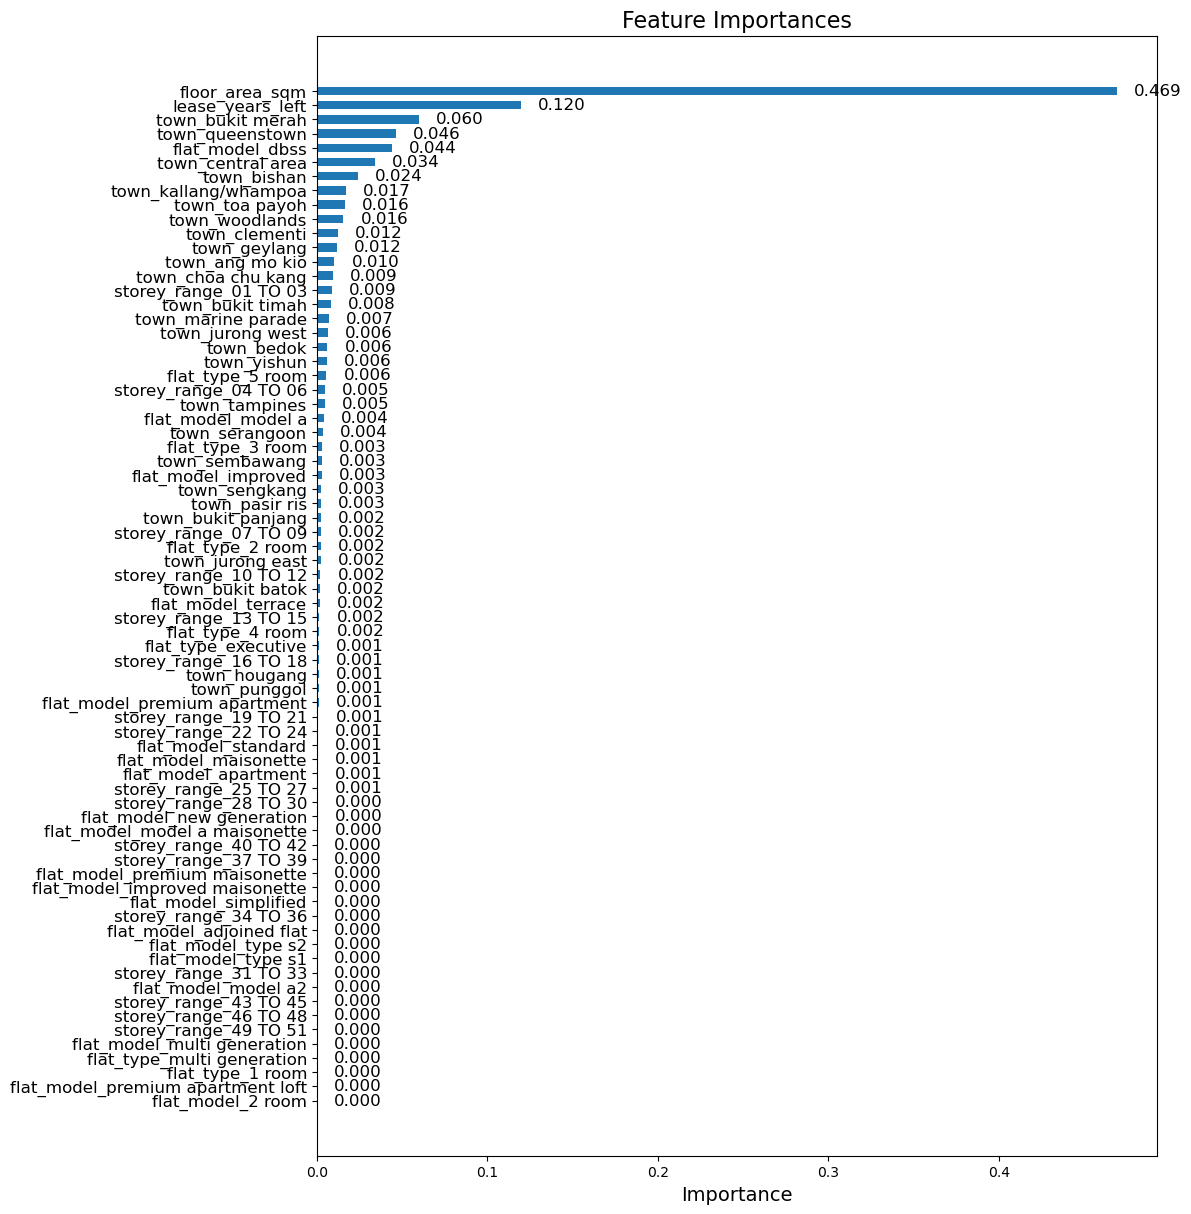

In [61]:
import matplotlib.pyplot as plt
import numpy as np

rf = rf_model.named_steps['regressor']
ohe = rf_model.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical)
numerical_features = [feat for feat in features if feat not in categorical]
feature_names = list(cat_feature_names) + numerical_features

importances = rf.feature_importances_
indices = np.argsort(importances)  # ascending order

plt.figure(figsize=(14, 14))  # Much taller figure for more vertical space
plt.title("Feature Importances", fontsize=16)

bars = plt.barh(range(len(importances)), importances[indices], align='center', height=0.6)  # thinner bars
plt.yticks(range(len(importances)), [feature_names[i] for i in indices], fontsize=12)
plt.xlabel("Importance", fontsize=14)

# Add value labels with more horizontal padding
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f"{width:.3f}", va='center', fontsize=12)

# Adjust subplot margins for extra left space and bottom space
plt.subplots_adjust(left=0.35, right=0.95, top=0.9, bottom=0.1)

plt.show()


In [62]:
# Pair feature names with their importance scores
feature_importance_pairs = list(zip(feature_names, importances))

# Sort by importance descending
feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Print neatly
print("Feature Importances:")
for feat, imp in feature_importance_pairs:
    print(f"{feat}: {imp:.4f}")


Feature Importances:
floor_area_sqm: 0.4691
lease_years_left: 0.1199
town_bukit merah: 0.0597
town_queenstown: 0.0463
flat_model_dbss: 0.0441
town_central area: 0.0340
town_bishan: 0.0241
town_kallang/whampoa: 0.0169
town_toa payoh: 0.0164
town_woodlands: 0.0156
town_clementi: 0.0124
town_geylang: 0.0115
town_ang mo kio: 0.0103
town_choa chu kang: 0.0092
storey_range_01 TO 03: 0.0089
town_bukit timah: 0.0084
town_marine parade: 0.0071
town_jurong west: 0.0063
town_bedok: 0.0062
town_yishun: 0.0057
flat_type_5 room: 0.0056
storey_range_04 TO 06: 0.0047
town_tampines: 0.0045
flat_model_model a: 0.0040
town_serangoon: 0.0037
flat_type_3 room: 0.0032
town_sembawang: 0.0030
flat_model_improved: 0.0028
town_sengkang: 0.0026
town_pasir ris: 0.0026
town_bukit panjang: 0.0024
storey_range_07 TO 09: 0.0024
flat_type_2 room: 0.0023
town_jurong east: 0.0022
storey_range_10 TO 12: 0.0021
town_bukit batok: 0.0020
flat_model_terrace: 0.0018
storey_range_13 TO 15: 0.0015
flat_type_4 room: 0.0015
flat_

In [63]:
import pandas as pd

# Your features
features = ['town', 'flat_type', 'storey_range', 'floor_area_sqm', 'flat_model', 'lease_years_left']

# Create a DataFrame of feature names and importances
fi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Map each one-hot encoded feature back to its original feature
def get_base_feature(name):
    for feat in features:
        if name.startswith(feat):
            return feat
    # Numerical features (which are passed through) have exact names
    if name in features:
        return name
    return 'other'

fi_df['base_feature'] = fi_df['feature'].apply(get_base_feature)

# Sum importances per base feature
summary = fi_df.groupby('base_feature')['importance'].sum().sort_values(ascending=False)

print(summary)


base_feature
floor_area_sqm      0.469136
town                0.315350
lease_years_left    0.119907
flat_model          0.057285
storey_range        0.024346
flat_type           0.013976
Name: importance, dtype: float64


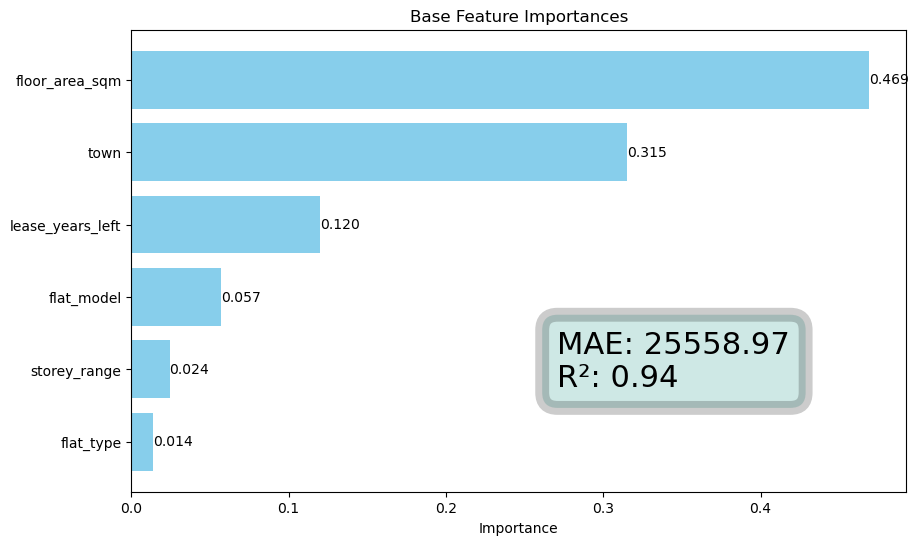

In [100]:
import matplotlib.pyplot as plt

# Your summarized data
features = ['floor_area_sqm', 'town', 'lease_years_left', 'flat_model', 'storey_range', 'flat_type']
importances = [0.469136, 0.315350, 0.119907, 0.057285, 0.024346, 0.013976]

# Example metric values — replace with your actual values
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

plt.figure(figsize=(10, 6))
bars = plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Base Feature Importances')

# Add value labels to bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', va='center')

plt.gca().invert_yaxis()  # Highest importance on top

# Annotate evaluation metrics
metrics_text = f'MAE: {mae:.2f}\nR²: {r2:.2f}'
plt.text(0.55, 0.35, metrics_text, transform=plt.gca().transAxes,
         fontsize=22, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', linewidth = 10, edgecolor = "#000000FF", facecolor="#0E8C7D63", alpha=0.2))

plt.show()


In [109]:
import joblib

# Save the pipeline to a file
joblib.dump(rf_model, 'rf_model_pipeline.joblib')
print("Model saved!")

# Later, to load the model back:
loaded_model = joblib.load('rf_model_pipeline.joblib')
# Then use loaded_model.predict() as usual

Model saved!


In [108]:
# Predict on test set
y_pred = rf_model.predict(X_test)

# Combine input features (X_test) and predictions in one DataFrame
results_df = X_test.copy()
results_df['actual_price'] = y_test.values  # actual values if available
results_df['predicted_price'] = y_pred      # predicted values

# Save to CSV
results_df.to_csv('model_predictions.csv', index=False)
print("Model predictions saved to 'model_predictions.csv'")

results_df

Model predictions saved to 'model_predictions.csv'


,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_years_left,actual_price,predicted_price
738163,bedok,4 room,13 TO 15,84.0,improved,60.00,365000.0,380360.656568
808616,ang mo kio,3 room,01 TO 03,70.0,model a,91.75,415000.0,409870.000000
781811,jurong east,5 room,07 TO 09,122.0,improved,68.17,560000.0,585900.000000
731405,central area,3 room,04 TO 06,74.0,model a,67.00,372000.0,386588.000000
811786,sengkang,5 room,07 TO 09,110.0,improved,81.75,485000.0,422581.800000
...,...,...,...,...,...,...,...,...
746968,punggol,5 room,07 TO 09,113.0,premium apartment,95.00,600000.0,618316.666667
778738,woodlands,5 room,01 TO 03,121.0,improved,80.25,350000.0,396787.333333
719644,choa chu kang,4 room,01 TO 03,102.0,model a,82.00,305000.0,318059.824000
740894,punggol,4 room,01 TO 03,93.0,premium apartment,92.00,420000.0,421170.833333


In [46]:
import joblib

model = joblib.load('path/to/your/model.joblib')
print(type(model))
print(model)


FileNotFoundError: [Errno 2] No such file or directory: 'path/to/your/model.joblib'